# Assignment No 2
## Paper Number 7
## Title: Title here
text here

------------------------------
Code to make initialization easier, can be ignored since requirements.txt is not handed in.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import Dependancies
This part of the code imports necessary Python libraries for the implementation of the Naming Game model:

- Mesa: An agent-based modeling framework that provides a structure for implementing the model
- NumPy: For numerical operations and array handling
- Pandas: For data manipulation and analysis
- Seaborn: For statistical data visualization
- Matplotlib: For creating plots and graphs
- Random: For generating random values and selections
- Scipy: Installed as part of Mesa and used later to fit certain distributions to histogram bins.

In [170]:
#!/usr/bin/env python3.11
!python --version

import mesa
print(f"mesa version: {mesa.__version__}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import networkx as nx

DEBUGSTEP = False

Python 3.12.10
mesa version: 3.2.0


Create random Graph

In [3]:
# code for random graph

Create Agent

In [4]:
from mesa import Agent

# code for agents
class GraphAgent(Agent):
    def __init__(self, model, starting_state, threshold_dist):
        super().__init__(model)
        self.state = starting_state
        self.theta = threshold_dist()

    def step(self):
        if self.state == 1:
            return
        # get neighbors and if a certain percentage is above a chosen threshold change state
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if not neighbors:
            return
        changed_state_amount = sum([1 for neighbor in neighbors if neighbor.state == 1])
        percentage_changed = changed_state_amount / len(neighbors)
        if percentage_changed > self.theta:
            self.state = 1
    
    @property
    def vulnerable_vertex_degree(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if not neighbors:
            k = 0
            p_vulnerable = 1
        else:
            k = len(neighbors)
            p_vulnerable = 1/len(neighbors)
        return p_vulnerable * self.model.p_uniform * (self.state**k) #TODO not sure about what x is, right now using the state

    @property
    def cascade_condition(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if not neighbors:
            k = 0
            p_vulnerable = 1
        else:
            k = len(neighbors)
            p_vulnerable = 1/len(neighbors)
        return p_vulnerable * self.model.p_uniform * (k*(k-1))

    @property
    def neighbor_amount(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if neighbors:
            return len(neighbors)
        else:
            return 0

Create Model

In [152]:
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import Model
from random import sample

# code for model
class GraphModel(Model):
    def __init__(self, threshold_dist, num_nodes=20, avg_degree=2, starting_state=0, graph=None, seed=None):
        super().__init__(seed=seed)
        self.avg_degree = avg_degree
        self.num_agents = num_nodes

        # Generate a sparse random graph using NetworkX
        if graph is None:
            self.p_uniform = avg_degree / (num_nodes - 1)
            self.G = nx.fast_gnp_random_graph(num_nodes, self.p_uniform, 42)
        else:
            self.G = graph
        self.grid = NetworkGrid(self.G)

        # Create an agent for each node
        GraphAgent.create_agents(model=self, n=num_nodes, starting_state=starting_state, threshold_dist=threshold_dist)
        for i, agent in enumerate(self.agents):
            self.grid.place_agent(agent, i)
            
        self.datacollector = DataCollector(
            model_reporters={"Total_average_State": "total_average_state",
                             "Vulnerable_Population_Fraction": "vulnerable_population",
                             #"Is_Cascading": "is_cascading",
                             "Empirical_mean": "empirical_threshold",
                             "Empirical_degrees":"empirical_degrees"}
        )

    def step(self):
        self.agents.shuffle_do("step")
        #self.agents.do("advance")
        self.datacollector.collect(self)
        
    def perturb_agents(self, theta):
        perturb_amount = int(self.num_agents * theta)
        chosen_agents = sample(self.agents, perturb_amount)
        for agent in chosen_agents:
            agent.state = 1
        
    @property
    def total_average_state(self):
        return np.mean([a.state for a in self.agents])
    
    @property
    def vulnerable_population(self):
        return len([a.vulnerable_vertex_degree for a in self.agents if a.vulnerable_vertex_degree > 0])
    
    @property
    def is_cascading(self):
        cascade_condition = sum([a.cascade_condition for a in  self.agents])
        return cascade_condition > self.avg_degree
    
    @property
    def empirical_threshold(self):
        return np.mean([a.theta for a in self.agents])
    
    @property
    def empirical_degrees(self):
        return np.mean([a.neighbor_amount for a in self.agents])

Run Model

In [160]:
def run_model(N, D, t, starting_state, threshold_dist, iteration, p_perturb, graph=None):
    modulo = max(1, int(t/10))
    print(f"Starting model iteration: {iteration}")
    model = GraphModel(threshold_dist, N, D, starting_state, graph)
    model.perturb_agents(p_perturb)
    for i in range(t):
        if i % modulo == 0 and DEBUGSTEP:
            print(f"iter: {iteration}, step: {i}")
            
        model.step()

    model_data = model.datacollector.get_model_vars_dataframe()
    graph = model.G
    #agent_data = model.agent_datacollector.get_agent_vars_dataframe()
    return model_data, graph, model

Threshold distributions for the individual agents

In [342]:
MEAN = 0.2
STANDARD_DEVIATION = 0.05

#threshold distributions
def homogonous_dist(mean=MEAN):
    return mean

def uniform_dist(mean=MEAN):
    ALPHA = 2
    beta = (ALPHA/mean)-ALPHA
    return random.betavariate(ALPHA, beta)

def normal_dist(mean=MEAN, std=STANDARD_DEVIATION):
    sample = np.random.normal(loc=mean, scale=std)
    return np.clip(sample, 0, 1)

simulating

Starting model iteration: 1


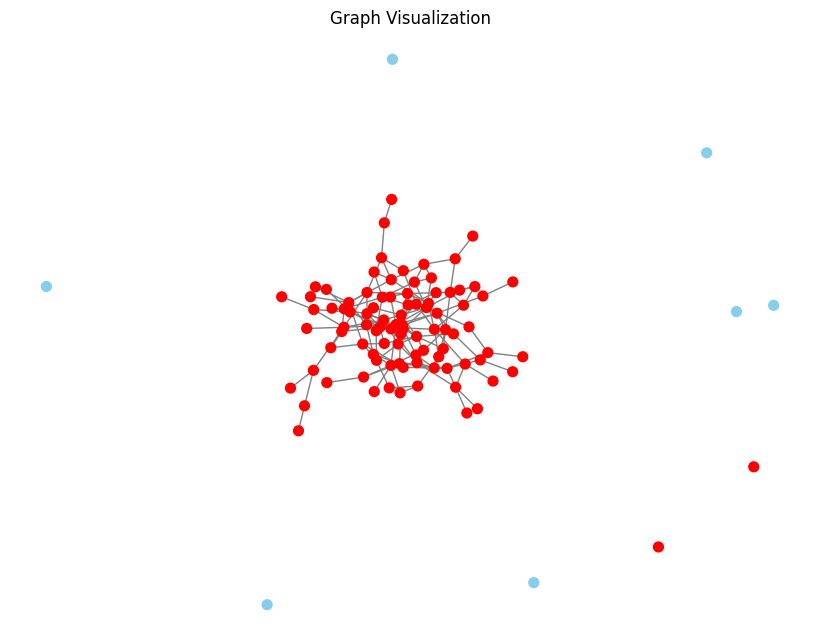

,Total_average_State,Vulnerable_Population_Fraction,Empirical_mean,Empirical_degrees
0,0.13,20,0.193105,3.0
1,0.59,66,0.193105,3.0
2,0.86,93,0.193105,3.0
3,0.93,100,0.193105,3.0
4,0.93,100,0.193105,3.0
5,0.93,100,0.193105,3.0
6,0.93,100,0.193105,3.0
7,0.93,100,0.193105,3.0
8,0.93,100,0.193105,3.0
9,0.93,100,0.193105,3.0


In [360]:
N = 100
AVG_DEGREE = 3
time = 15

STARTING_STATE = 0
POSSIBLE_STATES = [0,1] #TODO currently unused, delete later if it stays this way
PERTURB_PROPABILITY = 0.05

model_data, graph, model = run_model(N, AVG_DEGREE, time, STARTING_STATE, normal_dist, 1, PERTURB_PROPABILITY, graph=None)
if N <= 100:
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    states = [agent.state for agent in model.agents]
    node_colors = ['red' if state == 1 else 'skyblue' for state in states]
    nx.draw(graph, pos, node_size=50, node_color=node_colors, edge_color='gray', with_labels=False)
    plt.title(f"Graph Visualization")
    plt.show()
model_data